In [1]:
!pip install apimoex

In [2]:
import numpy as np
import pandas as pd
import apimoex
import requests

import matplotlib.pyplot as plt
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib as ta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4645    0  4645    0     0  14100      0 --:--:-- --:--:-- --:--:-- 14075
100  517k  100  517k    0     0   751k      0 --:--:-- --:--:-- --:--:--  751k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4645    0  4645    0     0  18678      0 --:--:-- --:--:-- --:--:-- 18654
100  392k  100  392k    0     0   563k      0 --:--:-- --:--:-- --:--:--  563k


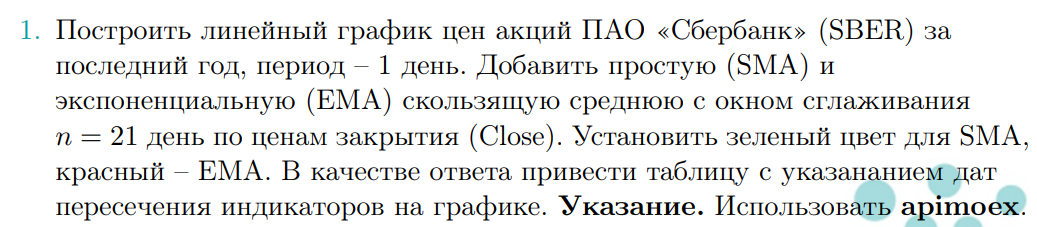

In [3]:
def obtein_data(ticker, start, end):
    with requests.Session() as session:
        data = apimoex.get_market_candles(session, ticker, start=start, end=end)
        df = pd.DataFrame(data)
    return df

def prepare_data(df):
    df['Date'] = pd.to_datetime(df['begin'])
    df.drop('begin', axis=1, inplace=True)
    df = df.reset_index(drop=True)
    return df

In [4]:
START_DATE = '2022-09-12'
END_DATE = '2023-09-12'
INSTUMENT = 'SBER'

In [5]:
df = prepare_data(obtein_data(INSTUMENT, START_DATE, END_DATE))

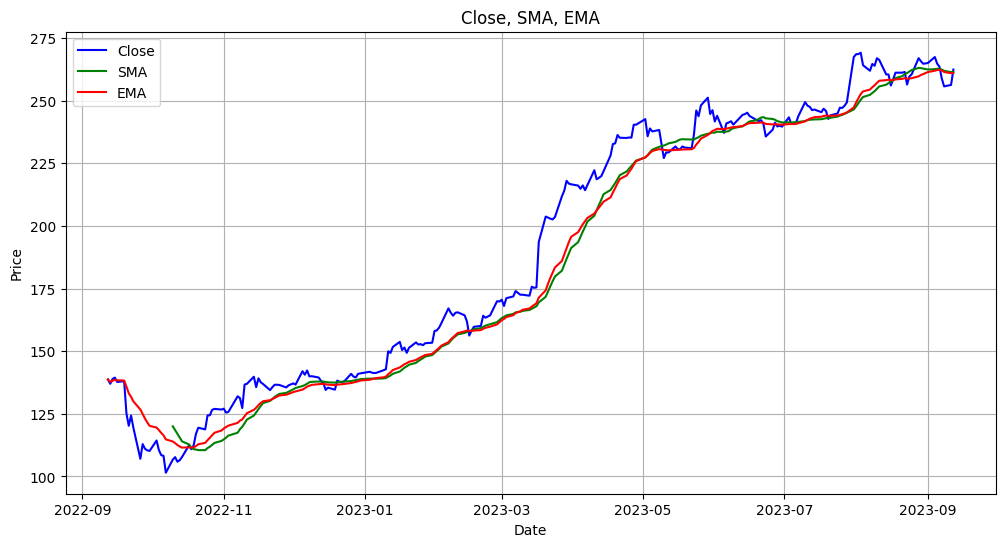

In [6]:
plt.figure(figsize=(12,6))
plt.title('Close, SMA, EMA')
plt.plot(df['Date'], df['close'], 'blue')
plt.plot(df['Date'], df['close'].rolling(window=21).mean(), 'green')
plt.plot(df['Date'], df['close'].ewm(span=21).mean(), 'red')
plt.legend(['Close', 'SMA', 'EMA'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

In [7]:
df[1:][(df['close'].rolling(window=21).mean()[1:] - df['close'].ewm(span=21).mean()[1:]).values*(df['close'].rolling(window=21).mean()[:-1] - df['close'].ewm(span=21).mean()[:-1]).values <0].Date

26    2022-10-18
50    2022-11-22
81    2023-01-05
111   2023-02-16
124   2023-03-09
147   2023-04-11
161   2023-05-02
162   2023-05-03
180   2023-05-30
190   2023-06-14
209   2023-07-11
237   2023-08-18
Name: Date, dtype: datetime64[ns]

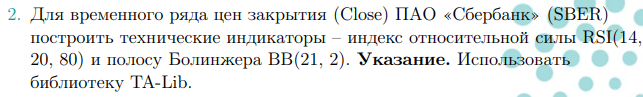

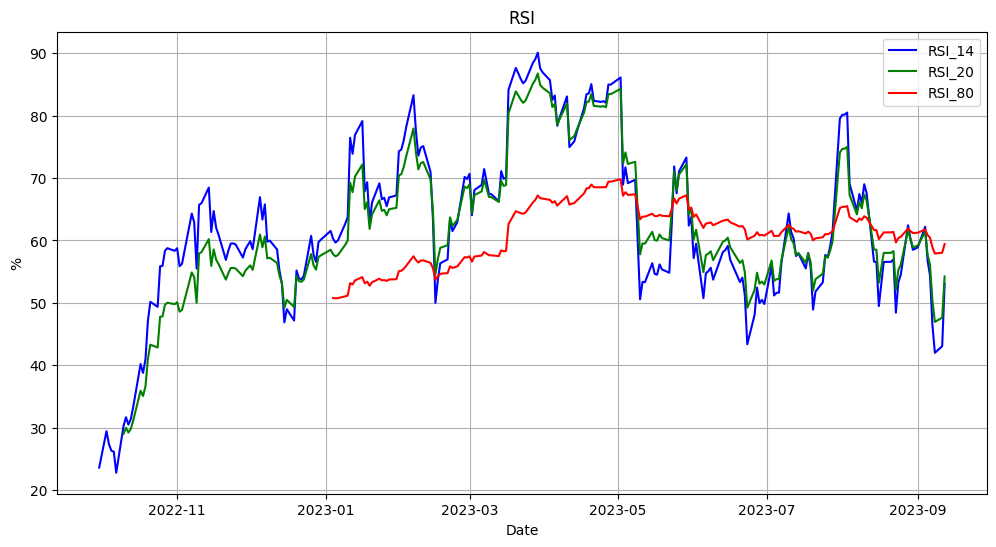

In [8]:
plt.figure(figsize=(12,6))
plt.title('RSI')
plt.plot(df['Date'], ta.RSI(df['close'], timeperiod=14), 'blue')
plt.plot(df['Date'], ta.RSI(df['close'], timeperiod=20), 'green')
plt.plot(df['Date'], ta.RSI(df['close'], timeperiod=80), 'red')
plt.legend(['RSI_14', 'RSI_20', 'RSI_80'])
plt.xlabel('Date')
plt.ylabel('%')
plt.grid()
plt.show()

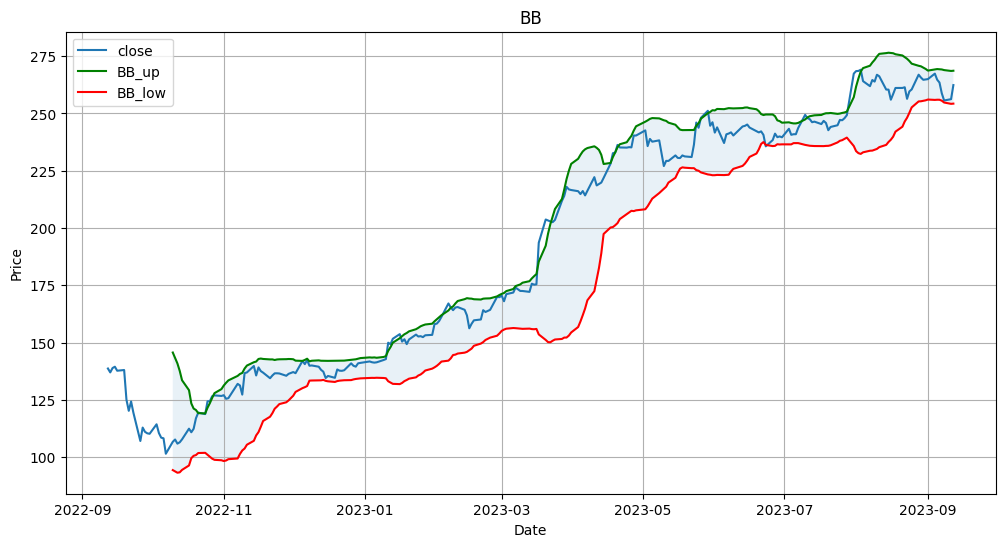

In [9]:
upperband, middleband, lowerband = ta.BBANDS(df['close'], timeperiod=21, nbdevup=2, nbdevdn=2)
plt.figure(figsize=(12,6))
plt.title('BB')
plt.plot(df['Date'], df['close'])
plt.plot(df['Date'], upperband, 'green')
plt.plot(df['Date'], lowerband, 'red')
plt.fill_between(df['Date'], lowerband, upperband, alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend(['close', 'BB_up', 'BB_low'])
plt.show()

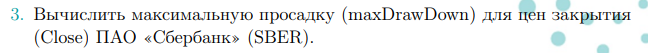

In [10]:
def stocks_income(price_close = df['close']):
    return  price_close / price_close.shift(1)-1

def drawdown(income = stocks_income()):
    r = income.add(1).cumprod()
    dd = r.div(r.cummax()).sub(1)
    return min(dd[1:])


drawdown(stocks_income())

-0.27229710352738756

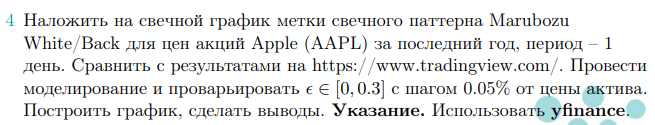

In [11]:
import yfinance as yf
df_aapl = yf.download('AAPL','2022-10-25','2023-10-25')
df_aapl

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-25,150.089996,152.490005,149.360001,152.339996,151.441589,74732300
2022-10-26,150.960007,151.990005,148.039993,149.350006,148.469223,88194300
2022-10-27,148.070007,149.050003,144.130005,144.800003,143.946045,109180200
2022-10-28,148.199997,157.500000,147.820007,155.740005,154.821548,164762400
2022-10-31,153.160004,154.240005,151.919998,153.339996,152.435699,97943200
...,...,...,...,...,...,...
2023-10-18,175.580002,177.580002,175.110001,175.839996,175.839996,54764400
2023-10-19,176.039993,177.839996,175.190002,175.460007,175.460007,59302900
2023-10-20,175.309998,175.419998,172.639999,172.880005,172.880005,64189300


In [12]:
ta.CDLMARUBOZU(open=df_aapl['Open'],
                high=df_aapl['High'],
                low=df_aapl['Low'],
                close=df_aapl['Close'])

Date
2022-10-25      0
2022-10-26      0
2022-10-27      0
2022-10-28      0
2022-10-31      0
             ... 
2023-10-18      0
2023-10-19      0
2023-10-20   -100
2023-10-23      0
2023-10-24      0
Length: 251, dtype: int32

In [13]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

fig = go.Figure(data=[go.Candlestick(x=df_aapl.index,
                open=df_aapl['Open'],
                high=df_aapl['High'],
                low=df_aapl['Low'],
                close=df_aapl['Close'])])

fig.show()

In [14]:
marobozu = ta.CDLCLOSINGMARUBOZU(df_aapl['Open'],
                                df_aapl['High'],
                                df_aapl['Low'],
                                df_aapl['Close'])

marobozu = pd.DataFrame({'value': marobozu[marobozu != 0],})
marobozu['color'] = np.where( marobozu['value'] > 0,'white','black')
marobozu['place'] = np.where(marobozu['value'] > 0,
                             df_aapl['Close'][marobozu.index] + 5,
                             df_aapl['Close'][marobozu.index] - 5)
marobozu['style'] = np.where(marobozu['color'] == 'white','triangle-up','triangle-down')
fig = go.Figure(data=[go.Candlestick(name='Candlestick',
                        x=df_aapl.index,
                        open=df_aapl['Open'],
                        close=df_aapl['Close'],
                        high=df_aapl['High'],
                        low=df_aapl['Low'],
                        increasing_line_color= 'green',
                        decreasing_line_color= 'red'),
                      go.Scatter(
                      name='Marobozu',
                      x=marobozu.index,
                      y=marobozu['place'],
                      mode = 'markers',
                      marker=dict(color=marobozu['color'],
                          showscale=False,
                          line=dict(color='Black',width=1),
                          symbol=marobozu['style'],
                          size=8))])
fig.update_layout(
    autosize=False,
    width=1400,
    height=700,)
fig.update_layout(
    yaxis_title='AAPL price',
    xaxis_title='Date')
fig.add_trace(go.Scatter())


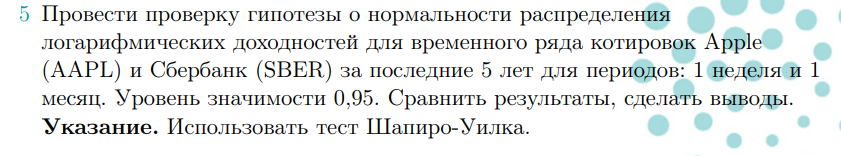

In [15]:
from scipy.stats import shapiro
#Тест Шапиро-Уилка проверяет нулевую гипотезу о том, что данные были взяты из нормального распределения.


H0 = Данные были взяты из нормального распределения

In [16]:
def stocks_ln_income(price_close = df['close']):
    return  np.log(price_close / price_close.shift(1))

In [17]:
shapiro(stocks_ln_income()[1:])

ShapiroResult(statistic=0.8739357590675354, pvalue=1.245195353077877e-13)

Гипотеза H0 отвергается p_v < 0.05

In [18]:
shapiro(stocks_ln_income(df_aapl['Close'])[1:])

ShapiroResult(statistic=0.9470939040184021, pvalue=7.16059318506268e-08)

Гипотеза H0 отвергается p_v < 0.05

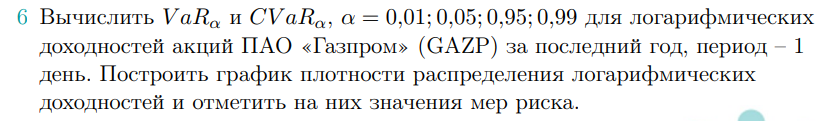

In [19]:
with requests.Session() as session:
    data = apimoex.get_market_candles(
        session,
        'GAZP',
        start='2022-10-23',
        end='2023-10-23',
        )
    gazpClose = prepare_data(pd.DataFrame(data))['close']

In [20]:
log_returns = np.log(gazpClose / gazpClose.shift(1))
historical_returns = log_returns.dropna()
print(historical_returns)

1      0.040911
2     -0.002323
3      0.002845
4     -0.010140
5     -0.002698
         ...   
249   -0.003367
250   -0.010463
251    0.001175
252    0.005910
253   -0.005852
Name: close, Length: 253, dtype: float64


In [21]:
days = 50

range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()
print(range_returns)

50    -0.018050
51    -0.067056
52    -0.059165
53    -0.058254
54    -0.051870
         ...   
249   -0.004294
250   -0.025125
251   -0.036139
252   -0.028529
253   -0.038568
Name: close, Length: 204, dtype: float64


-0.14731963771932466
8


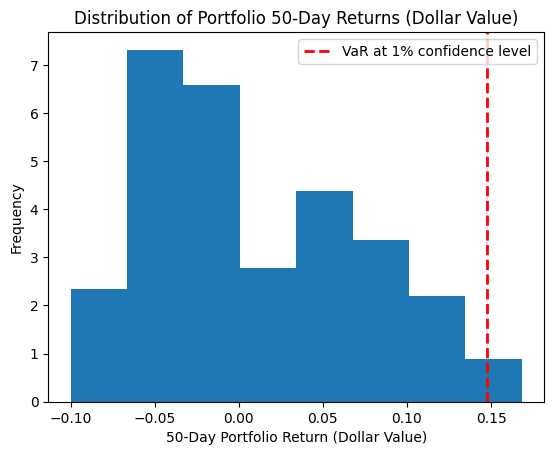

CVaR = -0.03117 при alpha = 0.01 

-0.12656193079487896
8


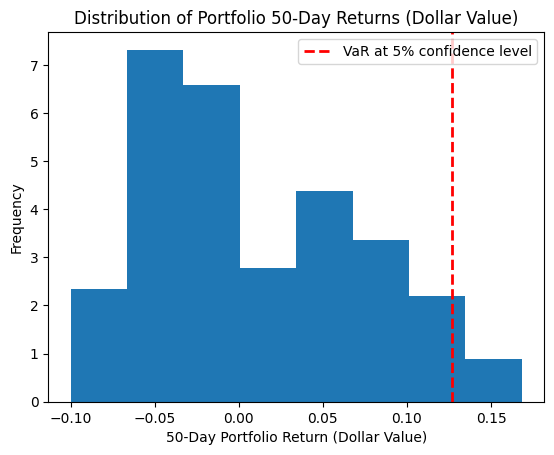

CVaR = -0.02312 при alpha = 0.05 

0.07110433089895063
8


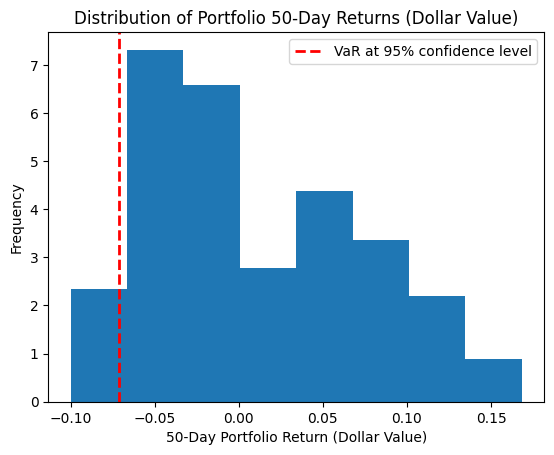

CVaR = -0.00154 при alpha = 0.95 

0.09208389708342193
8


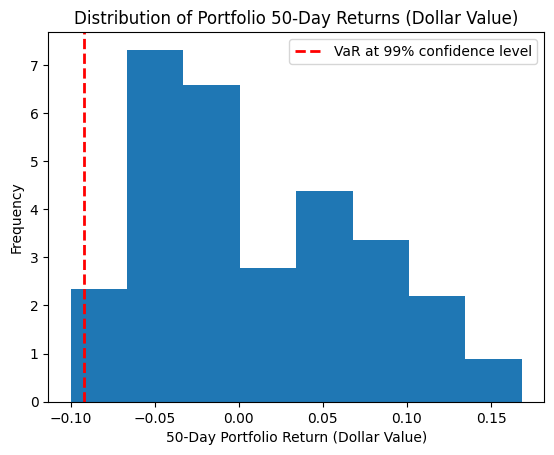

CVaR = -0.00051 при alpha = 0.99 



In [25]:
for i in [ 0.01,0.05, 0.95, 0.99]:
  confidence_interval = i

  VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100))
  print(VaR)
  return_window = days
  range_returns = historical_returns.rolling(window=return_window).sum()
  range_returns = range_returns.dropna()

  range_returns_dollar = range_returns
  bin_ = 1 + int(np.log2(len(range_returns_dollar.dropna())))
  print(bin_)
  plt.hist(range_returns_dollar.dropna(), bins=bin_, density=True)
  plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
  plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
  plt.legend()
  plt.show()
  print(f'CVaR = {round(np.mean(historical_returns[historical_returns < historical_returns.quantile(i)]),5)} при alpha = {i} ')
  print()